# Credit Card Fraud Detection using an Autoencoder in TensorFlow

In [1]:
%matplotlib inline

In [41]:
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, precision_recall_curve
import tensorflow as tf
from tensorflow.python.summary.writer import writer_cache
import glob
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.5, rc={'figure.figsize':(14, 8)})

# This is just to make TensorFlow use only one of my GPUs.
os.environ["CUDA_VISIBLE_DEVICES"]="0"

First read in the data.  We'll be using a dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).  
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015  

The data consists of a transaction time, several features that are the result of PCA transformations due to confidentiality issues, the transaction amount, and whether or not the transaction was fraudulent.

In [3]:
data = pd.read_csv('creditcard.csv')
display(data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
LABELS = ['Non-Fraud', 'Fraud']

The data is very imbalanced.

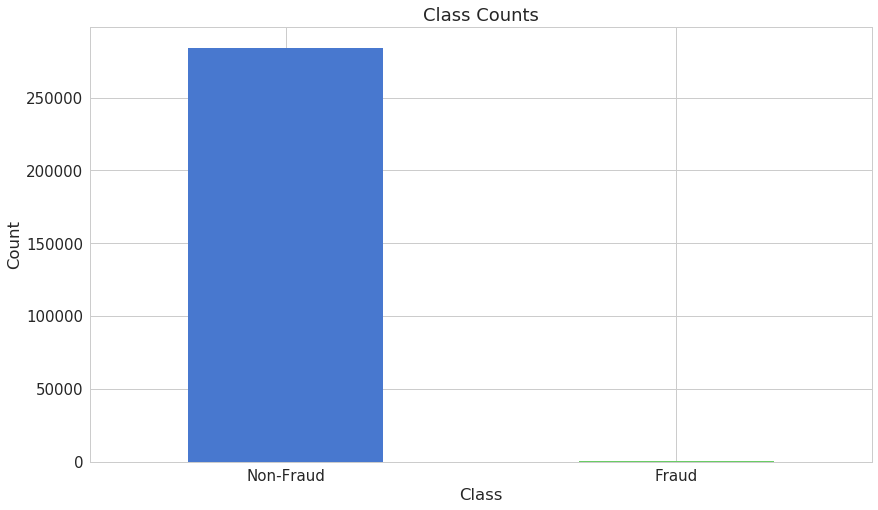

In [7]:
ax = data['Class'].value_counts().plot(kind='bar', rot=0)
ax.set_title('Class Counts');
ax.set_ylabel('Count');
ax.set_xlabel('Class');
ax.set_xticklabels(LABELS);

See if there is a difference in the amount distribution between fraudulent and non-fraudulent transactions.

In [8]:
non_frauds = data.loc[data['Class'] == 0]
frauds = data.loc[data['Class'] == 1]

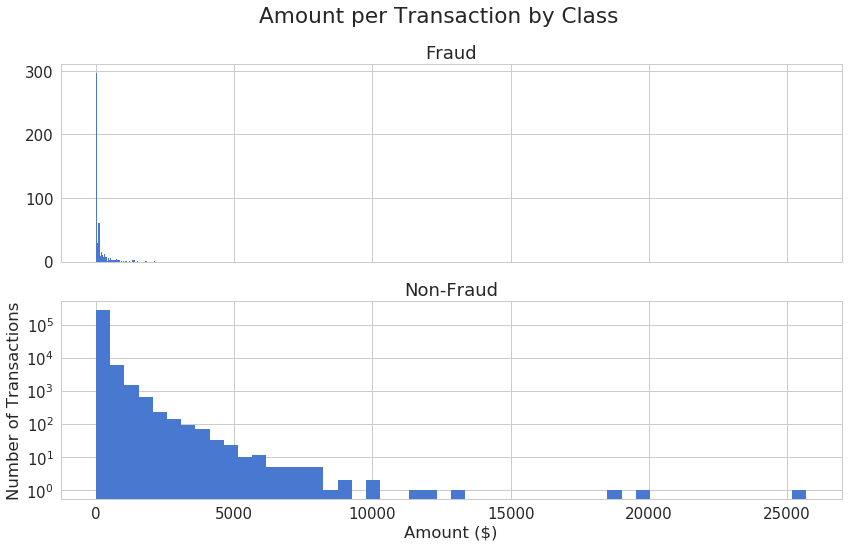

In [9]:
# Compare the distribution of amount by class.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per Transaction by Class')

bins = 50

ax1.hist(frauds['Amount'], bins=bins);
ax1.set_title('Fraud');

ax2.hist(non_frauds['Amount'], bins=bins);
ax2.set_title('Non-Fraud');
ax2.set_xlabel('Amount ($)');
ax2.set_ylabel('Number of Transactions');
ax2.set_yscale('log')

See if there is a pattern in the transaction time for fraudulent transactions.

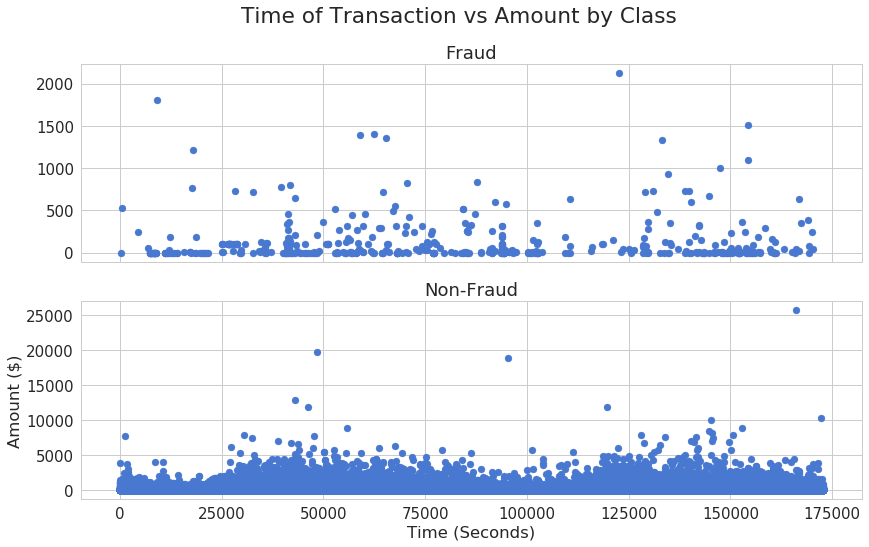

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of Transaction vs Amount by Class');

ax1.scatter(frauds['Time'], frauds['Amount']);
ax1.set_title('Fraud');

ax2.scatter(non_frauds['Time'], non_frauds['Amount']);
ax2.set_title('Non-Fraud');
ax2.set_xlabel('Time (Seconds)');
ax2.set_ylabel('Amount ($)');

Get the data ready to run through the autoencoder.  Throw away the transaction time because there doesn't seem to be a pattern between it and fraudulent transactions.  Normalize the amount and split the dataset into train and test.  Since this is an autoencoder, labels are not used for training.

In [11]:
data = data.drop(columns=['Time'])
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [12]:
train_features, test_features = train_test_split(data, test_size=0.2)
train_features = train_features[train_features['Class'] == 0]
train_features = train_features.drop(columns=['Class'])

test_labels = test_features['Class']
test_features = test_features.drop(columns=['Class'])

display(data['Class'].value_counts())
display(train_features.shape)
display(test_features.shape)
display(test_labels.shape)
display(test_labels.value_counts())

0    284315
1       492
Name: Class, dtype: int64

(227458, 29)

(56962, 29)

(56962,)

0    56857
1      105
Name: Class, dtype: int64

In [13]:
train_features.to_csv('./train_features.csv', index=False)
test_features.to_csv('./test_features.csv', index=False)
test_labels.to_csv('./test_labels.csv', index=False)

## TensorFlow Implementation

### Define the Feature Columns
These are all numeric value columns so this is easy.

In [14]:
def get_feature_columns(features):
    return [tf.feature_column.numeric_column(key=c) for c in features.columns]

### Define the input pipelines

In [15]:
COLUMNS = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
           'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
           'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

FIELD_DEFAULTS = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],
                  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],
                  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],
                  [0.0], [0.0]]

def _parse_line(line):
    fields = tf.decode_csv(line, FIELD_DEFAULTS)
    features = dict(zip(COLUMNS, fields))
    return (features, tf.constant(0, dtype=tf.int32))

def train_input_fn(batch_size=50, num_epochs=100):
    dataset = tf.data.TextLineDataset('./train_features.csv').skip(1)
    dataset = dataset.apply(tf.contrib.data.map_and_batch(map_func=_parse_line, batch_size=batch_size, num_parallel_batches=4))
    dataset = dataset.cache()
    dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=1000, count=num_epochs))
    dataset = dataset.prefetch(1)
    return dataset
    
def test_input_fn(batch_size=50):
    dataset = tf.data.TextLineDataset('./test_features.csv').skip(1)
    dataset = dataset.apply(tf.contrib.data.map_and_batch(map_func=_parse_line, batch_size=batch_size, num_parallel_batches=4))
    dataset = dataset.prefetch(1)
    return dataset

### Define the autoencoder model
It's really just a regular neural network that funnels down into a small number of hidden units in the middle and then back up to the original number of features - which effectively forces the network to generalize and "denoise" the data.

In [16]:
def create_autoencoder_model(features, labels, mode, params):
    input_layer = tf.feature_column.input_layer(features, params['feature_columns'])
    
    hidden_layer = input_layer
    for layer_index, layer_size in enumerate(params['hidden_layers']):
        hidden_layer = tf.layers.dense(hidden_layer, 
                                       units=layer_size, 
                                       activation=params['activation_function'], 
                                       name='Hidden{0}'.format(layer_index))
    
    output_layer = tf.layers.dense(hidden_layer, units=len(features), name='OutputLayer')
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        estimator_spec = tf.estimator.EstimatorSpec(mode, predictions=output_layer)
   
    else:
        loss = tf.losses.mean_squared_error(labels=input_layer, predictions=output_layer, reduction=tf.losses.Reduction.MEAN)
    
        if mode == tf.estimator.ModeKeys.EVAL:
            estimator_spec = tf.estimator.EstimatorSpec(mode, loss=loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
            estimator_spec = tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        
    return estimator_spec

class ValidationHook(tf.train.SessionRunHook):
    def __init__(self, model_fn, params, input_fn, model_dir, every_n_secs=None, every_n_steps=None):
        self._iter_count = 0
        self._estimator = tf.estimator.Estimator(model_fn=model_fn, params=params, model_dir=model_dir)
        self._input_fn = input_fn
        self._timer = tf.train.SecondOrStepTimer(every_n_secs, every_n_steps)
        self._should_trigger = False
        
    def begin(self):
        self._timer.reset()
        self._iter_count = 0
        
    def before_run(self, run_context):
        self._should_trigger = self._timer.should_trigger_for_step(self._iter_count)
        
    def after_run(self, run_context, run_values):
        if self._should_trigger:
            self._estimator.evaluate(self._input_fn)
            self._timer.update_last_triggered_step(self._iter_count)
        self._iter_count = self._iter_count + 1

### Train
I have a rudimentary grid to test different network shapes, activation functions, and learning rates.

In [17]:
# Parameters to grid
network_shapes = {'shallow': [5], 'medium': [15, 5, 15], 'deep': [25, 20, 15, 10, 5, 10, 15, 20, 25]}
activation_functions = [tf.nn.tanh, tf.nn.relu]
learning_rates = [0.01, 0.001, 0.0001]

# Create the grid
grid = dict()
for network_shape, hidden_layers in network_shapes.items():
    for activation_function in activation_functions:
        for learning_rate in learning_rates:
            run_name = '{0}_{1}_{2}'.format(network_shape, activation_function.__name__, learning_rate)
            grid[run_name] = (hidden_layers, activation_function, learning_rate)

In [40]:
%%time

# Run everything in the grid
tf.logging.set_verbosity('WARN')
writer_cache.FileWriterCache.clear()
feature_columns = get_feature_columns(train_features)
#validation_steps = 500
#config = tf.estimator.RunConfig(save_checkpoints_steps=validation_steps)
results = pd.DataFrame(columns=['train_error', 'test_error'])
            
for run_name, hyperparameters in grid.items():
    hidden_layers, activation_function, learning_rate = hyperparameters
    
    model_dir = './model/{0}'.format(run_name)
    
    params = {'feature_columns': feature_columns,
              'hidden_layers': hidden_layers,
              'activation_function': activation_function,
              'learning_rate': learning_rate}

    autoencoder = tf.estimator.Estimator(model_fn=create_autoencoder_model,
                                         model_dir=model_dir,
                                         params=params)
    
    #autoencoder.train(input_fn=train_input_fn(batch_size=100000, num_epochs=250),
    #                  hooks=[ValidationHook(model_fn=create_autoencoder_model,
    #                                        input_fn=test_input_fn(batch_size=100000),
    #                                        params=params,
    #                                        model_dir=model_dir,
    #                                        every_n_steps=validation_steps)]);
    
    autoencoder.train(input_fn=lambda: train_input_fn(batch_size=100, num_epochs=250))
    
    train_results = autoencoder.evaluate(input_fn=lambda: train_input_fn(batch_size=100, num_epochs=1), name='train')
    test_results = autoencoder.evaluate(input_fn=lambda: test_input_fn(batch_size=100), name='test')
    
    results.loc[run_name] = (train_results['loss'], test_results['loss'])
    print('{0}: train loss: {1} test loss: {2}'.format(run_name, train_results['loss'], test_results['loss']))

shallow_relu_0.001: train loss: 0.5921235680580139 test loss: 0.6505300402641296
deep_tanh_0.001: train loss: 0.18244007229804993 test loss: 0.21219827234745026
deep_relu_0.01: train loss: 1.028325080871582 test loss: 1.1040220260620117
medium_relu_0.001: train loss: 0.31523779034614563 test loss: 0.35515061020851135
shallow_relu_0.0001: train loss: 0.5916600227355957 test loss: 0.6496378779411316
medium_tanh_0.001: train loss: 0.33989444375038147 test loss: 0.3887031674385071
medium_relu_0.01: train loss: 0.6388639807701111 test loss: 0.6996474862098694
shallow_tanh_0.01: train loss: 0.6388422250747681 test loss: 0.7100263237953186
medium_tanh_0.01: train loss: 0.36424368619918823 test loss: 0.4176260828971863
deep_relu_0.0001: train loss: 0.24132667481899261 test loss: 0.28724735975265503
medium_tanh_0.0001: train loss: 0.37536799907684326 test loss: 0.42415496706962585
deep_relu_0.001: train loss: 0.22888699173927307 test loss: 0.27027860283851624
deep_tanh_0.01: train loss: 0.98848

### Predict
With the luxury of having the labels, we can see if the autoencoder is any good for detecting frauds.  To do this, we can run the test set through the trained model and compare the original data to the resulting data by calculating the error between between the two sets.  The error between the two sets is sort of a measure of how far from "normal" the example is and the result we are hoping for is that the fraudulent transactions are picked up within these abnormal transactions.

In [20]:
%%time
run_name = 'deep_tanh_0.001'
hidden_layers, activation_function, learning_rate = grid[run_name]
feature_columns = get_feature_columns(train_features)

autoencoder = tf.estimator.Estimator(model_fn=create_autoencoder_model,
                                     model_dir='./model/{0}'.format(run_name),
                                     params={'feature_columns': feature_columns,
                                             'hidden_layers': hidden_layers,
                                             'activation_function': activation_function,
                                             'learning_rate': learning_rate})

predictions = np.array(list(autoencoder.predict(input_fn=lambda: test_input_fn(batch_size=100), checkpoint_path='./model/deep_tanh_0.001/model.ckpt-568750')))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3e23af5c0>, '_is_chief': True, '_master': '', '_task_id': 0, '_service': None, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_evaluation_master': '', '_model_dir': './model/deep_tanh_0.001', '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_train_distribute': None, '_log_step_count_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/deep_tanh_0.001/model.ckpt-568750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
CPU times: user 10.7 s, sys: 449 ms, total: 11.1 s
Wall 

In [21]:
predictions.shape

(56962, 29)

In [22]:
errors = np.mean(np.power(test_features.values - predictions, 2), axis=1)
results = pd.DataFrame({'error': errors, 'class': test_labels})
results.describe()

,class,error
count,56962.000000,56962.000000
mean,0.001843,2.044868
std,0.042895,6.719979
min,0.000000,0.288843
25%,0.000000,0.794034
50%,0.000000,1.167390
75%,0.000000,1.808430
max,1.000000,429.234518


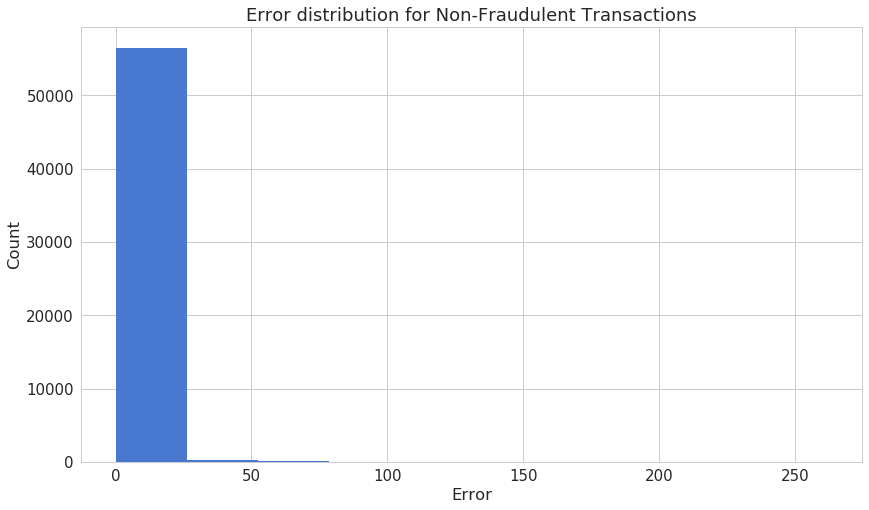

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
non_frauds = results.loc[(results['class'] == 0) & (results['error'] < 300)]
ax.hist(non_frauds['error'].values, bins=10);
ax.set_title('Error distribution for Non-Fraudulent Transactions')
ax.set_ylabel('Count');
ax.set_xlabel('Error');

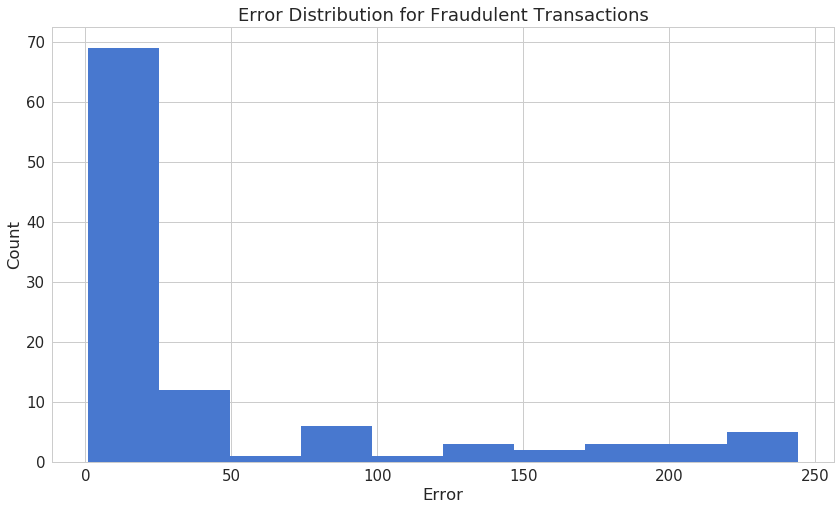

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
frauds = results.loc[results['class'] == 1]
ax.hist(frauds['error'].values, bins=10);
ax.set_title('Error Distribution for Fraudulent Transactions')
ax.set_ylabel('Count');
ax.set_xlabel('Error');

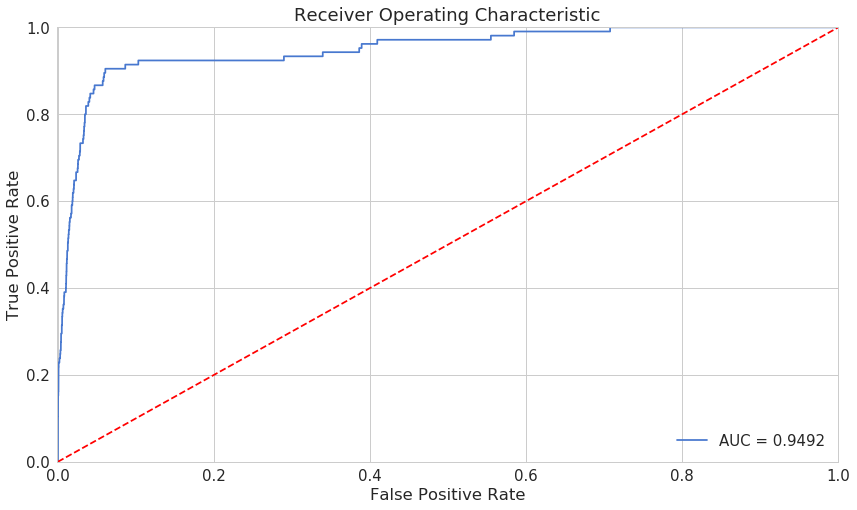

In [25]:
fpr, tpr, thresholds = roc_curve(results['class'], results['error'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

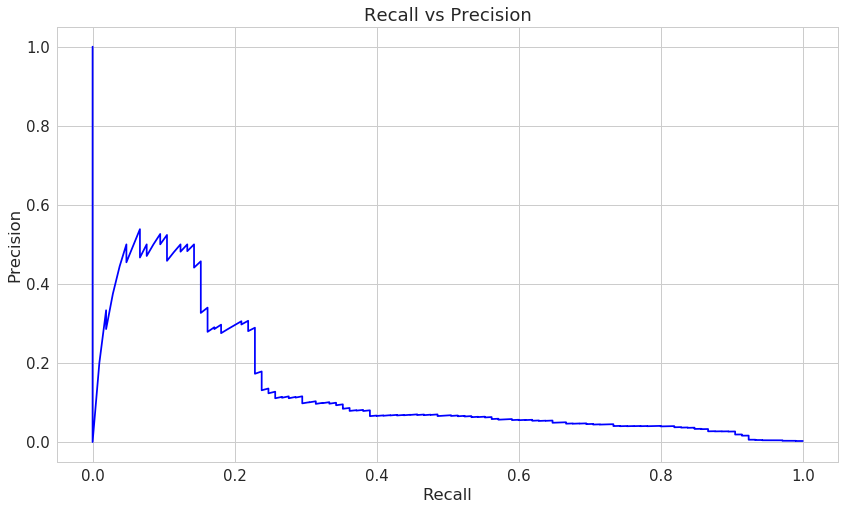

In [26]:
precision, recall, thresholds = precision_recall_curve(results['class'], results['error'])
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

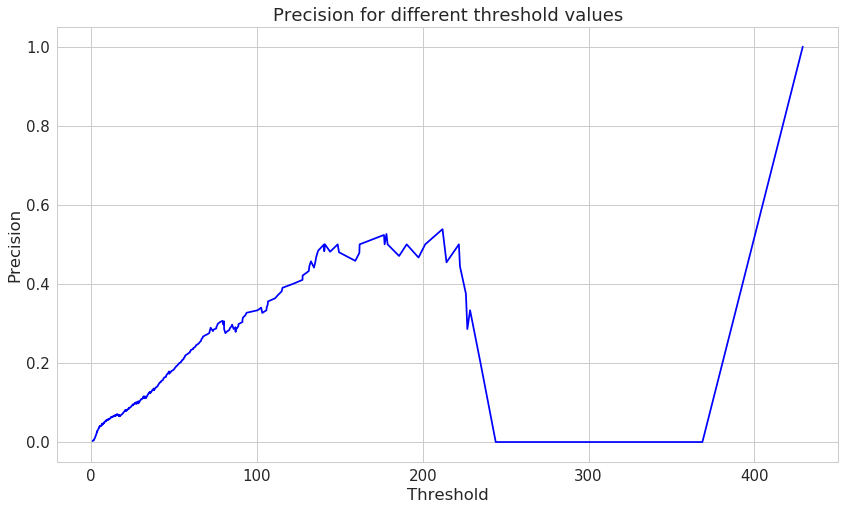

In [27]:
plt.plot(thresholds, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

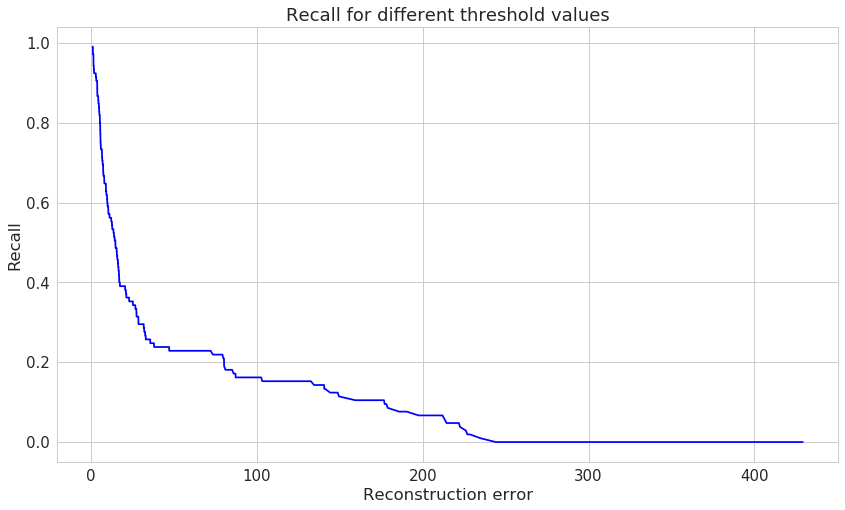

In [28]:
plt.plot(thresholds, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

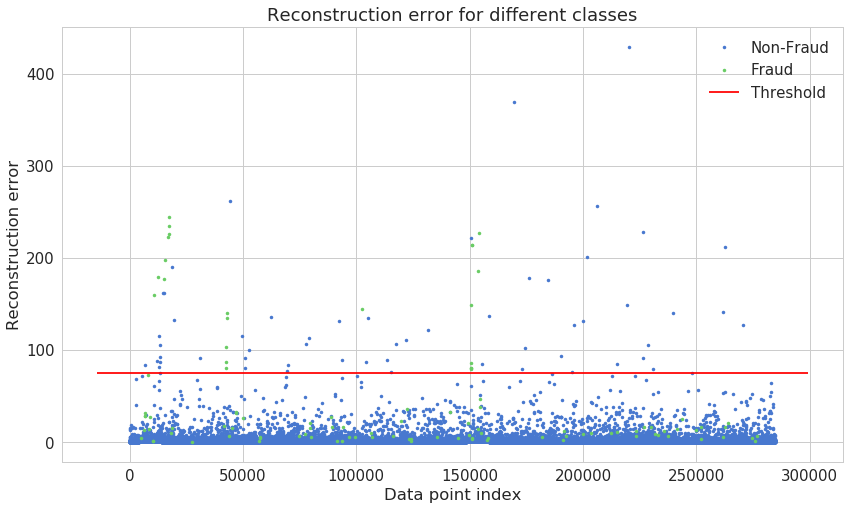

In [38]:
threshold = 75

groups = results.groupby('class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group['error'], marker='o', ms=3.5, linestyle='', label= "Fraud" if name == 1 else "Non-Fraud")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

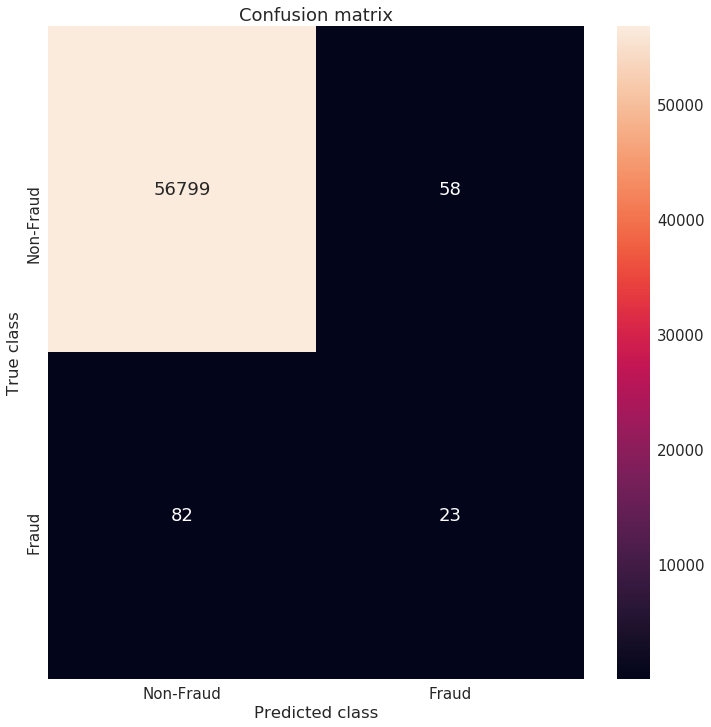

In [39]:
y_pred = [1 if e > threshold else 0 for e in results['error'].values]
conf_matrix = confusion_matrix(results['class'], y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [40]:
display('precision: {0}'.format(precision_score(y_true=results['class'], y_pred=y_pred)))
display('recall: {0}'.format(recall_score(y_true=results['class'], y_pred=y_pred)))

'precision: 0.2839506172839506'

'recall: 0.21904761904761905'